# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = 'baseline'
genre_name = 'cello'
composer_name='Bach'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 1
rnn_units = 128
use_attention = True
reg = None
#reg = regularizers.l2(0.01)
#reg = regularizers.l1_l2(l1=0.1,l2=0.1)
learning_rate = 0.001

## Extract the notes

In [3]:
data_folder

'data/cello/Bach'

In [4]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            #notes.extend(['START'])
            #durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

36 files in total
1 Parsing data/cello/Bach/cs1-2all.mid
2 Parsing data/cello/Bach/cs5-1pre.mid
3 Parsing data/cello/Bach/cs4-1pre.mid
4 Parsing data/cello/Bach/cs3-5bou.mid
5 Parsing data/cello/Bach/cs1-4sar.mid
6 Parsing data/cello/Bach/cs2-5men.mid
7 Parsing data/cello/Bach/cs3-3cou.mid
8 Parsing data/cello/Bach/cs2-3cou.mid
9 Parsing data/cello/Bach/cs1-6gig.mid
10 Parsing data/cello/Bach/cs6-4sar.mid
11 Parsing data/cello/Bach/cs4-5bou.mid
12 Parsing data/cello/Bach/cs4-3cou.mid
13 Parsing data/cello/Bach/cs5-3cou.mid
14 Parsing data/cello/Bach/cs6-5gav.mid
15 Parsing data/cello/Bach/cs6-6gig.mid
16 Parsing data/cello/Bach/cs6-2all.mid
17 Parsing data/cello/Bach/cs2-1pre.mid
18 Parsing data/cello/Bach/cs3-1pre.mid
19 Parsing data/cello/Bach/cs3-6gig.mid
20 Parsing data/cello/Bach/cs2-6gig.mid
21 Parsing data/cello/Bach/cs2-4sar.mid
22 Parsing data/cello/Bach/cs3-4sar.mid
23 Parsing data/cello/Bach/cs1-5men.mid
24 Parsing data/cello/Bach/cs1-3cou.mid
25 Parsing data/cello/Bach/cs6-

## Create the lookup tables

In [5]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [6]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B2': 2,
 'A2.C3': 3,
 'A2.C3.D3.E3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.A4': 32,
 'A3.B3.C#4': 33,
 'A3.B3.C4': 34,
 'A3.B3.F#4.G4': 35,
 'A3.B3.G4': 36,
 'A3.C#4': 37,
 'A3.C#4.E4': 38,
 'A3.C4': 39,
 'A3.D4': 40,
 'A3.D4.E4': 41,
 'A3.D4.F#4': 42,
 'A3.E4': 43,
 'A3.E4.F#4': 44,
 'A3.E4.F#4.G4': 45,
 'A3.E4.G4': 46,
 'A3.F#4': 47,
 'A3.F#4.G4': 48,
 'A3.F4': 49,
 'A3.G#4.A4': 50,
 'A3.G4': 51,
 'A4': 52,
 'A4.B4': 53,
 'B-2': 54,
 'B-2.A3': 55,
 'B-2.B-3': 56,
 'B-2.D3': 57,
 'B-2.D3.A3': 58,
 'B-2.D3.E-3.G#3': 59,
 'B-2.D3.G#3': 

In [7]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

## Prepare the sequences used by the Neural Network

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460
 460 460 460 460 460 460 460 460 460 460 460 460 460 460]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

## Create the structure of the neural network

In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention, reg, learning_rate)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1)      461         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1)      19          input_2[0][0]                    
____________________________________________________________________________________________

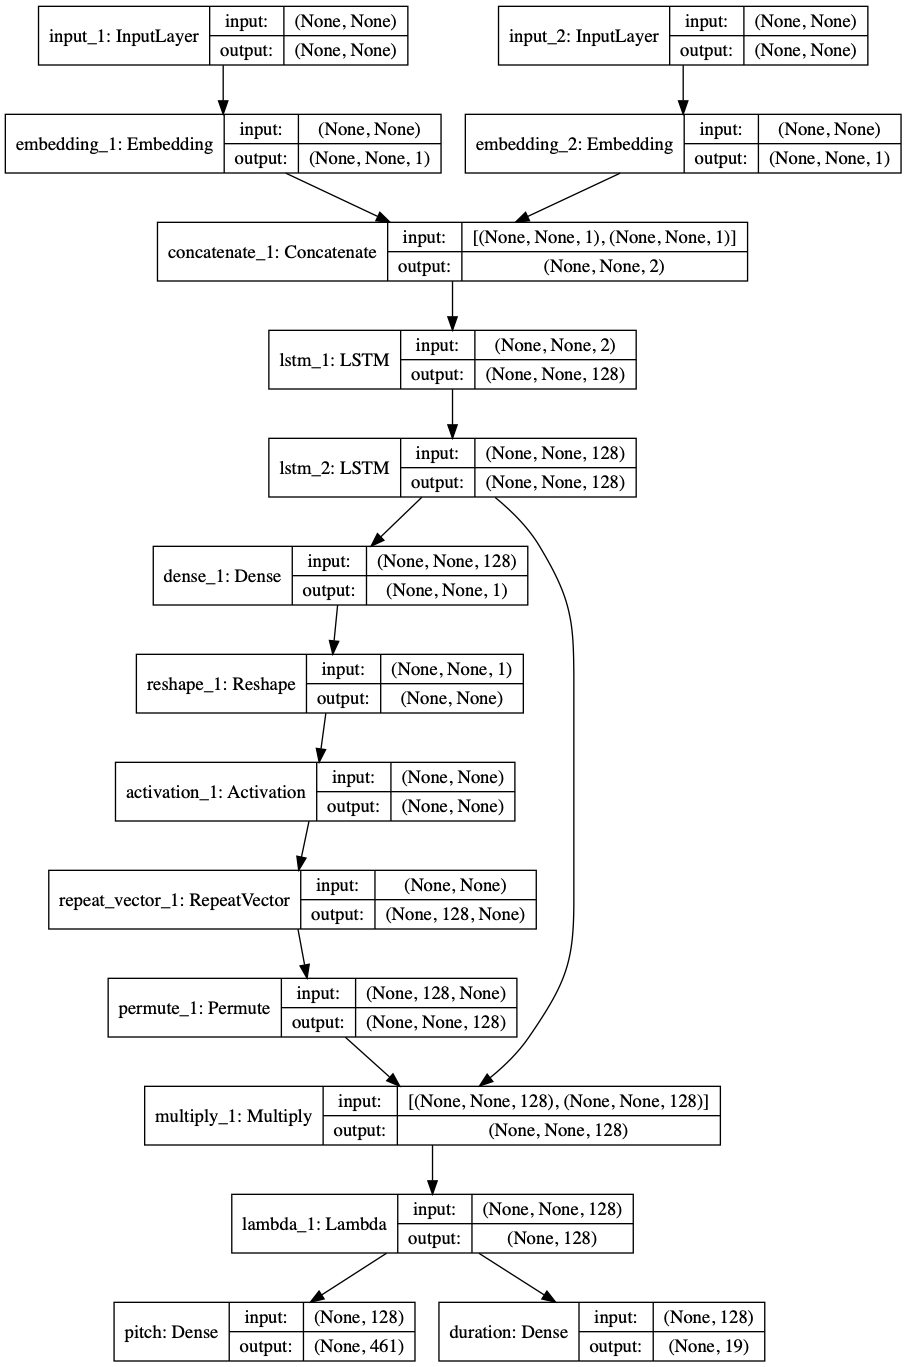

In [11]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [13]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=1000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 23024 samples, validate on 5757 samples
Epoch 1/1000
23024/23024 [==============================] - 119s 5ms/step - loss: 4.8945 - pitch_loss: 3.7833 - duration_loss: 1.1103 - val_loss: 4.9897 - val_pitch_loss: 3.6842 - val_duration_loss: 1.3053
Epoch 2/1000
23024/23024 [==============================] - 123s 5ms/step - loss: 4.4022 - pitch_loss: 3.5521 - duration_loss: 0.8500 - val_loss: 4.6033 - val_pitch_loss: 3.5043 - val_duration_loss: 1.0987
Epoch 3/1000
23024/23024 [==============================] - 135s 6ms/step - loss: 4.1423 - pitch_loss: 3.4077 - duration_loss: 0.7347 - val_loss: 4.1919 - val_pitch_loss: 3.2729 - val_duration_loss: 0.9190
Epoch 4/1000
23024/23024 [==============================] - 124s 5ms/step - loss: 4.0006 - pitch_loss: 3.3295 - duration_loss: 0.6714 - val_loss: 4.2027 - val_pitch_loss: 3.2607 - val_duration_loss: 0.9419
Epoch 5/1000
23024/23024 [==============================] - 111s 5ms/step - loss: 3.9061 - pitch_loss: 3.2849 - duration_loss: 

Epoch 80/1000
23024/23024 [==============================] - 94s 4ms/step - loss: 1.2232 - pitch_loss: 1.1427 - duration_loss: 0.0811 - val_loss: 8.1059 - val_pitch_loss: 5.8558 - val_duration_loss: 2.2492
Epoch 81/1000
23024/23024 [==============================] - 93s 4ms/step - loss: 1.2108 - pitch_loss: 1.1309 - duration_loss: 0.0796 - val_loss: 8.1281 - val_pitch_loss: 5.8507 - val_duration_loss: 2.2762
Epoch 82/1000
23024/23024 [==============================] - 91s 4ms/step - loss: 1.1987 - pitch_loss: 1.1203 - duration_loss: 0.0785 - val_loss: 8.1245 - val_pitch_loss: 6.0332 - val_duration_loss: 2.0907
Epoch 83/1000
23024/23024 [==============================] - 103s 4ms/step - loss: 1.1770 - pitch_loss: 1.0976 - duration_loss: 0.0791 - val_loss: 8.1927 - val_pitch_loss: 6.0243 - val_duration_loss: 2.1677
Epoch 84/1000
23024/23024 [==============================] - 101s 4ms/step - loss: 1.1600 - pitch_loss: 1.0828 - duration_loss: 0.0769 - val_loss: 8.3442 - val_pitch_loss: 6.0

23024/23024 [==============================] - 137s 6ms/step - loss: 0.6535 - pitch_loss: 0.6046 - duration_loss: 0.0487 - val_loss: 9.7455 - val_pitch_loss: 7.1939 - val_duration_loss: 2.5518
Epoch 159/1000
23024/23024 [==============================] - 143s 6ms/step - loss: 0.6529 - pitch_loss: 0.6059 - duration_loss: 0.0470 - val_loss: 10.1540 - val_pitch_loss: 7.3730 - val_duration_loss: 2.7807
Epoch 160/1000
23024/23024 [==============================] - 130s 6ms/step - loss: 0.6382 - pitch_loss: 0.5954 - duration_loss: 0.0430 - val_loss: 9.8215 - val_pitch_loss: 7.1204 - val_duration_loss: 2.7008
Epoch 161/1000
23024/23024 [==============================] - 125s 5ms/step - loss: 0.6344 - pitch_loss: 0.5867 - duration_loss: 0.0474 - val_loss: 9.8272 - val_pitch_loss: 7.0993 - val_duration_loss: 2.7277
Epoch 162/1000
23024/23024 [==============================] - 121s 5ms/step - loss: 0.6365 - pitch_loss: 0.5901 - duration_loss: 0.0462 - val_loss: 10.2743 - val_pitch_loss: 7.2382 -

/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.151578). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


23024/23024 [==============================] - 140s 6ms/step - loss: 0.5334 - pitch_loss: 0.4902 - duration_loss: 0.0430 - val_loss: 10.8818 - val_pitch_loss: 7.6974 - val_duration_loss: 3.1843
Epoch 216/1000
23024/23024 [==============================] - 139s 6ms/step - loss: 0.5318 - pitch_loss: 0.4877 - duration_loss: 0.0438 - val_loss: 10.9851 - val_pitch_loss: 7.6291 - val_duration_loss: 3.3553
Epoch 217/1000
23024/23024 [==============================] - 149s 6ms/step - loss: 0.5272 - pitch_loss: 0.4827 - duration_loss: 0.0442 - val_loss: 10.7994 - val_pitch_loss: 7.5826 - val_duration_loss: 3.2167
Epoch 218/1000
23024/23024 [==============================] - 145s 6ms/step - loss: 0.5287 - pitch_loss: 0.4880 - duration_loss: 0.0406 - val_loss: 11.0878 - val_pitch_loss: 7.6677 - val_duration_loss: 3.4194
Epoch 219/1000
23024/23024 [==============================] - 130s 6ms/step - loss: 0.5199 - pitch_loss: 0.4785 - duration_loss: 0.0419 - val_loss: 10.6909 - val_pitch_loss: 7.591

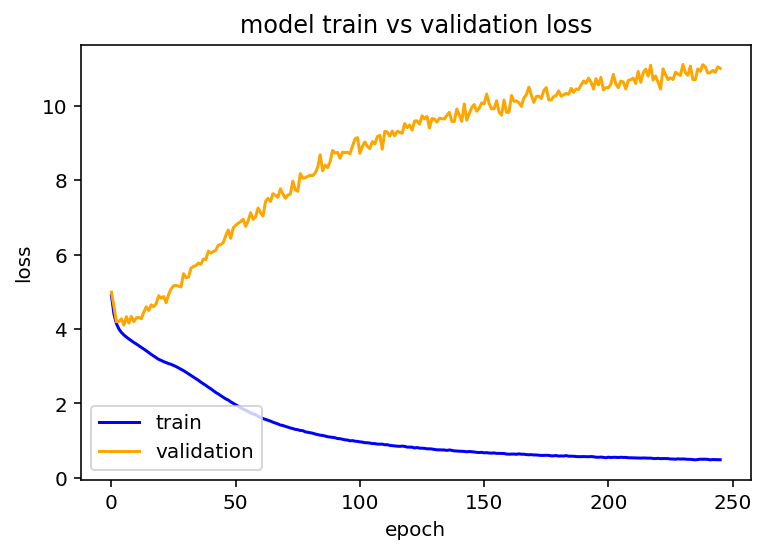

In [14]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()